In [1]:
%cd /app/
import time
import tensorflow as tf
from pathlib import Path
from src.model import create_model
from src.dataset import Dataset
import datetime
tf.keras.backend.clear_session()
import numpy as np
for gpu in tf.config.list_physical_devices('GPU'):
    print(gpu)
    tf.config.experimental.set_memory_growth(gpu, True)
#enable XLA
import matplotlib.pyplot as plt  
tf.config.optimizer.set_jit(True)
#enable mixed precision
# from tensorflow.keras.mixed_precision import experimental as mixed_precision
# policy = mixed_precision.Policy('mixed_float16')
# mixed_precision.set_policy(policy)
# print('Compute dtype: %s' % policy.compute_dtype)
# print('Variable dtype: %s' % policy.variable_dtype)



/app
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [2]:
ds_train, ds_val, class_weight, labels, IMAGE_SIZE, N_CLASSES = Dataset.read(batch_size=50)



In [9]:
it = ds_train.unbatch().skip(5).take(5).as_numpy_iterator()

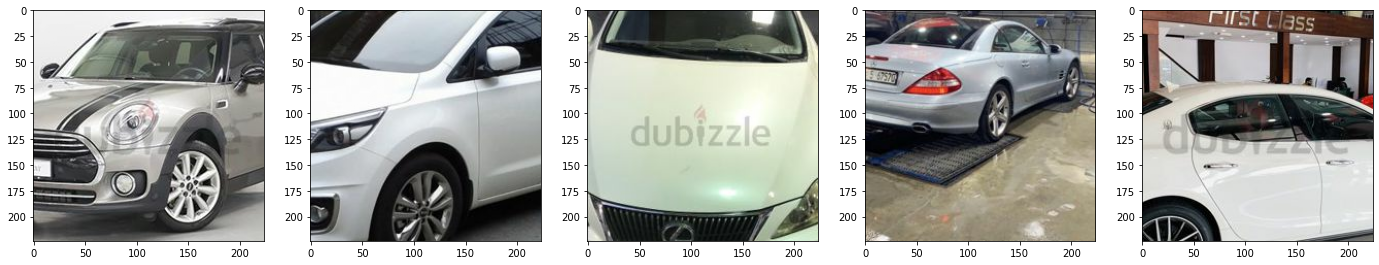

In [10]:
f, ax = plt.subplots(1,5, figsize=(24,6)) 
imgs = [img for img, label in it]
for i in range(5):
    ax[i].imshow(imgs[i])

In [12]:
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)
OUTPUT_SHAPE = N_CLASSES

Let's check some images

In [ ]:
model_name = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
print(model_name)
log_dir = Path('logs') / model_name
# log_dir = f"../logs/{model_name}"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=str(log_dir))

In [ ]:
checkpoint_dir = Path.cwd() / 'models' / model_name / 'cp{epoch:03d}.ckpt'

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=str(checkpoint_dir),
                                                 save_weights_only=True,
                                                 verbose=0)


In [ ]:
# with mirrored_strategy.scope():
lr = 0.0007

model = create_model((IMAGE_SIZE, IMAGE_SIZE, 3), OUTPUT_SHAPE)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=5)])
model.summary()



In [ ]:
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3,
                                                   patience=3, min_lr=0.0001)

In [ ]:
history = model.fit(ds_train,
                    epochs=100,
                    validation_data=ds_val,
                    class_weight=class_weight,
#                     steps_per_epoch=30,
#                      validation_steps=10,
                    callbacks=[
                        tensorboard_callback, 
                        lr_callback, 
                        cp_callback
                              ]
                   )
